In [1]:
!pip install tensorflow
!pip install matplotlib
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
datasets=tf.keras.utils.image_dataset_from_directory(
    "datasets",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1440 files belonging to 2 classes.


In [4]:
class_names = datasets.class_names
print(class_names)

['clean', 'dirty']


In [5]:
len(datasets)

45

In [6]:
for image_batch, label_batch in datasets.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0]


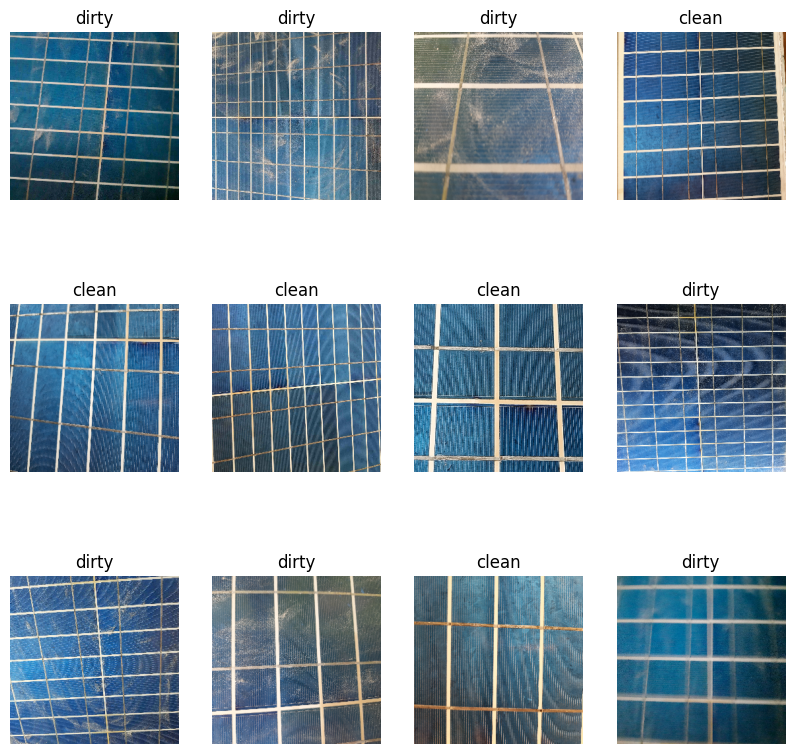

In [7]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in datasets.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [20]:
train_datasets = datasets.take(36)
len(train_datasets)

36

In [21]:
test_datasets = datasets.skip(36)
len(test_datasets)

9

In [22]:
val_datasets = test_datasets.take(5)
len(val_datasets)

5

In [23]:
test_datasets = test_datasets.skip(5)
len(test_datasets)

4

In [24]:
def get_datasets_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [25]:
train_ds, val_ds, test_ds= get_datasets_partitions_tf(datasets)

In [26]:
len(train_ds)

36

In [27]:
len(val_ds)

4

In [28]:
len(test_ds)

5

In [29]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [30]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [31]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape,),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape = input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history= model.fit(
    train_datasets,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_datasets
)

Epoch 1/50
36/36 [==============================] - 67s 2s/step - loss: 0.7635 - accuracy: 0.4861 - val_loss: 0.6848 - val_accuracy: 0.6062
Epoch 2/50
36/36 [==============================] - 66s 2s/step - loss: 0.6932 - accuracy: 0.5399 - val_loss: 0.6048 - val_accuracy: 0.7312
Epoch 3/50
36/36 [==============================] - 66s 2s/step - loss: 0.6246 - accuracy: 0.6441 - val_loss: 0.5412 - val_accuracy: 0.7000
Epoch 4/50
36/36 [==============================] - 65s 2s/step - loss: 0.5604 - accuracy: 0.7075 - val_loss: 0.5732 - val_accuracy: 0.7312
Epoch 5/50
36/36 [==============================] - 68s 2s/step - loss: 0.4826 - accuracy: 0.7812 - val_loss: 0.3406 - val_accuracy: 0.8500
Epoch 6/50
36/36 [==============================] - 68s 2s/step - loss: 0.3884 - accuracy: 0.8507 - val_loss: 0.3321 - val_accuracy: 0.8750
Epoch 7/50
36/36 [==============================] - 66s 2s/step - loss: 0.3372 - accuracy: 0.8707 - val_loss: 0.2864 - val_accuracy: 0.8938
Epoch 8/50
36/36 [==

Epoch 42/50
36/36 [==============================] - 71s 2s/step - loss: 0.0612 - accuracy: 0.9766 - val_loss: 0.0459 - val_accuracy: 0.9812
Epoch 43/50
36/36 [==============================] - 68s 2s/step - loss: 0.0822 - accuracy: 0.9714 - val_loss: 0.2132 - val_accuracy: 0.9312
Epoch 44/50
36/36 [==============================] - 64s 2s/step - loss: 0.1125 - accuracy: 0.9627 - val_loss: 0.0674 - val_accuracy: 0.9812
Epoch 45/50
36/36 [==============================] - 66s 2s/step - loss: 0.1204 - accuracy: 0.9592 - val_loss: 0.1067 - val_accuracy: 0.9563
Epoch 46/50
36/36 [==============================] - 65s 2s/step - loss: 0.0643 - accuracy: 0.9757 - val_loss: 0.1300 - val_accuracy: 0.9438
Epoch 47/50
36/36 [==============================] - 66s 2s/step - loss: 0.0699 - accuracy: 0.9757 - val_loss: 0.3933 - val_accuracy: 0.8813
Epoch 48/50
36/36 [==============================] - 67s 2s/step - loss: 0.0759 - accuracy: 0.9740 - val_loss: 0.0341 - val_accuracy: 0.9937
Epoch 49/50
3

In [36]:
scores= model.evaluate(test_datasets)
scores

4/4 [==============================] - 18s 216ms/step - loss: 0.2254 - accuracy: 0.9297


[0.22543573379516602, 0.9296875]

In [37]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 36}

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
len(history.history)

4

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

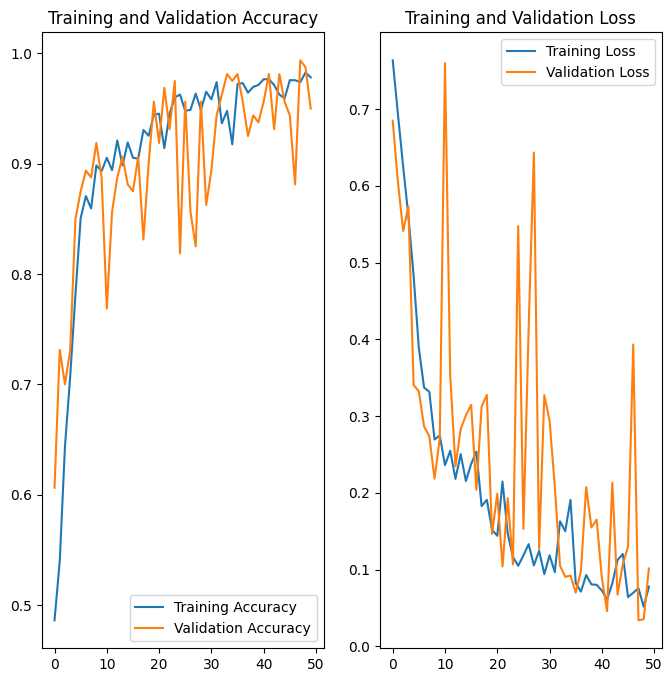

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: dirty
1/1 [==============================] - 0s 238ms/step
predicted label: dirty


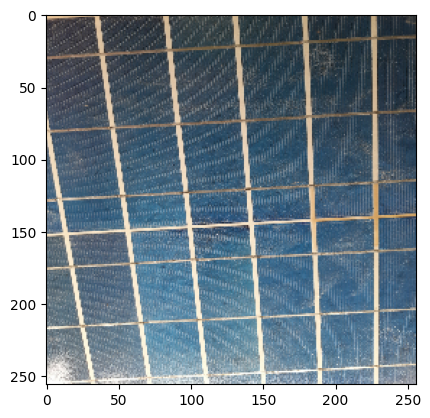

In [47]:
import numpy as np
for images_batch, labels_batch in test_datasets.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


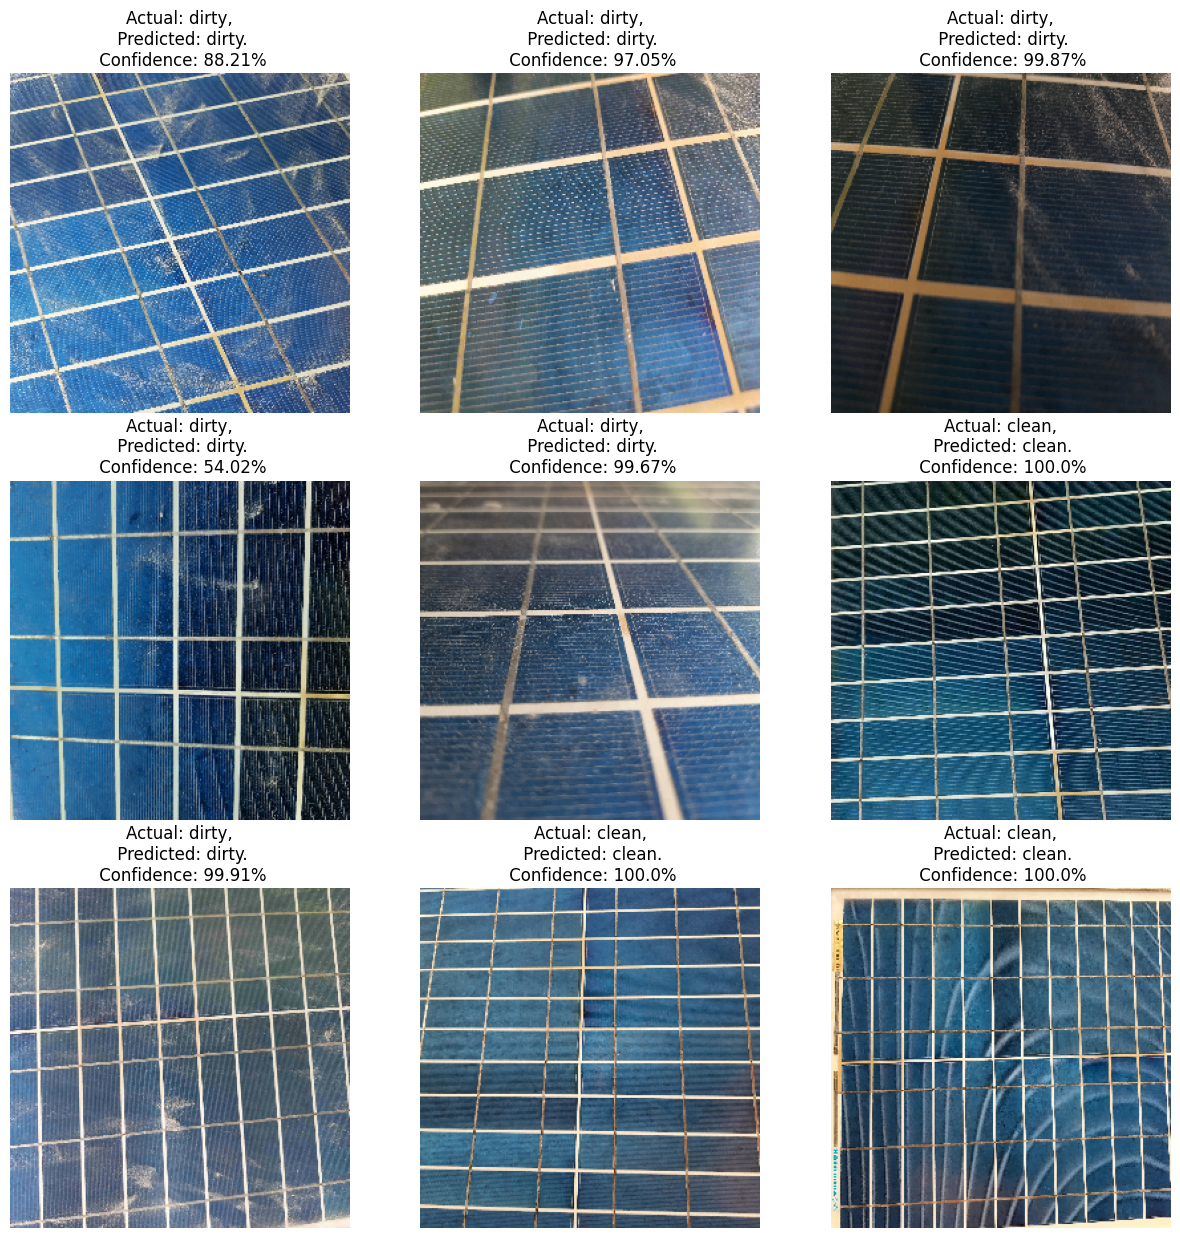

In [49]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [52]:
import os
model_version=max([int(i) for i in os.listdir("../save_solar_modelsv2") + [0]])+1
model.save(f"../save_solar_modelsv2/{model_version}")

INFO:tensorflow:Assets written to: ../save_solar_modelsv2/2\assets


INFO:tensorflow:Assets written to: ../save_solar_modelsv2/2\assets


In [53]:
model.save("../solarv2.h5")